In [1]:
import seaborn as sns
sns.set()

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. This tutorial will walk you through one way to build a machine learning algorithm.


## Metrics and scoring

For most questions, you are asked to submit your models `predict` method.

## Download and parse the incoming data


The training data are a series of JSON objects, in a Gzipped file. Python supports Gzipped files natively: [`gzip.open`](https://docs.python.org/3/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in `json` package has a `loads` function that converts a JSON string into a Python dictionary. We could call that once for each row of the file. [`ujson`](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` package, but is *substantially* faster (at the cost of non-robust handling of malformed JSON). We will use that inside a list comprehension to get a list of dictionaries:

In [4]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In scikit-learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features. Let's get in this habit now, by creating a separate list of the ratings.

In [6]:
star_ratings = [row['stars'] for row in data]
# star_ratings

A few things to consider:

1. The test set used by the grader will be in the same form as `data`. For this miniproject, it will be a list of dictionaries. The models you will build will need to handle data of this type; we'll discuss this more further in the questions.
1. You may find it useful to serialize your trained model using either [`dill`](https://pypi.python.org/pypi/dill) or [`joblib`](http://scikit-learn.org/stable/modules/model_persistence.html). That way, you can reload your model after restarting the Jupyter notebook without needing to retrain it.
1. There are obvious mistakes in the data; there is no need to try to correct them.

# Questions


## Question 1: city_avg

The venues belong to different cities.  You can imagine that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the data set. There are many ways to do this; please feel free to experiment on your own.  If you get stuck, the steps below attempt to guide you through the process.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city. At the end, we can just divide the stars by the count to get the average. We could create a separate sum and count variable for each city, but that will get tedious quickly. A better approach is to create a dictionary for each. The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The `collections` module's `defaultdict` class works around this by providing default values for keys that haven't been used. Thus, if we do

In [7]:
from collections import defaultdict

star_sum = defaultdict(int)
count = defaultdict(int)

we can increment any key of `star_sum` or `count` without first worrying whether the key exists. We need to go through the `data` and `star_ratings` list together, which we can do with the `zip` function.

In [8]:
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
    # increment the running count in count
    star_sum[row['city']] += stars
    count[row['city']] += 1

In [9]:
# star_sum ,count

Now we can calculate the average ratings.  Again, a dictionary makes a good container.

In [10]:
avg_stars = dict()
for city in star_sum:
    # calculate average star rating and store in avg_stars
    avg_stars[city]= star_sum[city]/count[city]

In [11]:
 sum(avg_stars.values()) / len(avg_stars)

3.7127593360958078

In [12]:
len(avg_stars)

167

There should be 167 different cities:

We can get that list of tuples by converting the returned view object from the `items` method into a list.

In [1]:
list(avg_stars.items())

NameError: name 'avg_stars' is not defined

## Question 2: city_model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `fit` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `predict` method can look up the average rating for the city of each record it receives.

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin

class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        star_sum = defaultdict(int)
        count = defaultdict(int)
        for row, stars in zip(X,y):
            star_sum[row['city']] += stars
            count[row['city']] += 1

        for city in star_sum:
            self.avg_stars[city]= star_sum[city]/count[city]
        return self
    
    def predict(self, X):
        result =[]
        average_star = sum(self.avg_stars.values()) / len(self.avg_stars)
        for row in X:
            if row['city'] in self.avg_stars:
                result.append(self.avg_stars[row['city']])
            else:
                result.append(average_star)
        return result

Now we can create an instance of our regressor and train it.

In [16]:
city_model = CityRegressor()
city_model.fit(data, star_ratings)

CityRegressor()

And let's see if it works.

In [17]:
city_model.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [18]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'}])

[3.6702903946388683, 3.7127593360958078, 3.6457337883959045]

## Question 3: lat_long_model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Since we need to select the appropriate columns from our dictionaries to build our latitude-longitude model, we will have to use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). However, the `ColumnTransformer` works with either NumPy arrays or pandas data frames. While we can convert our training data into a data frame easily, the test set the grader uses is a list of dictionaries. Thus, our first estimator in our workflow should be a transformer that converts a list of dictionaries into a pandas data frame.

In [20]:
import pandas as pd
from sklearn.base import TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        return  pd.DataFrame(X)

Let's test out the transformer.

In [21]:
to_data_frame = ToDataFrame()
X_t = to_data_frame.fit_transform(data[:5])

# Check that our transformer properly transform the input data into a data frame
grader.check((X_t == pd.DataFrame(data[:5])).all(axis=None))

True

Now we are ready to use `ColumnTransformer` and test it out.

In [22]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer([
    ('lat_long', 'passthrough', ['latitude','longitude'])
])
expected = np.array([data[0]['latitude'], data[0]['longitude']])

# Check that our selector returns just two columns, the latitude and longitude
grader.check((selector.fit_transform(X_t)[0] == expected).all())

True

Now, let's feed the output of the transformer in to a `KNeighborsRegressor`. As a sanity check, we'll test it with the first 5 rows.

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform)
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

We are not ready to submit to the grader; there are two things we still need to do:
1. Wrap all the steps necessary to go from our data (list of dictionaries) to predicted ratings
1. Determine the optimal value for our predictor's hyperparameter

For the first point, we will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. Remember that a pipeline is made with a list of `(step_name, estimator)` tuples.

In [24]:
len(data)

37938

In [25]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# to_data_frame = ToDataFrame()

# selector = ColumnTransformer([
#     ('lat_long', 'passthrough', ['latitude','longitude'])
# ])

# knn = KNeighborsRegressor(n_neighbors=5)

# parameters = {'n_neighbors':np.arange(90,121)}
# knn = KNeighborsRegressor()
# grid_knn = GridSearchCV(knn, parameters)


# pipe = Pipeline([
#         ('to_df',to_data_frame),
#         ('selector',selector),
#         ('knn_regressor_grid',grid_knn)
# ], verbose=True)

In [26]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

to_data_frame = ToDataFrame()

selector = ColumnTransformer([
    ('lat_long', 'passthrough', ['latitude','longitude'])
])

knn = KNeighborsRegressor(n_neighbors=5)

parameters = {'n_neighbors':np.arange(90,121)}
knn = KNeighborsRegressor()
grid_knn = GridSearchCV(knn, parameters, cv= KFold(n_splits=5, shuffle=True, random_state=1169))


pipe = Pipeline([
        ('to_df',to_data_frame),
        ('selector',selector),
        ('knn_regressor_grid',grid_knn)
], verbose=True)

Now let's fit and predict.

In [27]:
lat_long_to_star_ratings = pipe

lat_long_to_star_ratings.fit(data, star_ratings)
lat_long_to_star_ratings.predict(data[:5])

[Pipeline] ............. (step 1 of 3) Processing to_df, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline]  (step 3 of 3) Processing knn_regressor_grid, total=  21.3s


array([3.90322581, 3.43548387, 3.56989247, 3.6344086 , 3.56451613])

In [28]:
lat_long_to_star_ratings.named_steps['knn_regressor_grid'].best_params_   ###{'n_neighbors': 93}

{'n_neighbors': 93}

Let's now focus on the second point. The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. There is no reason to believe that 5 is the optimum value. We will need to determine a better value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). You may need to refer back to the notebooks about the ways to interface searching tools and pipelines.

You should consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. If you perform a train/test split with [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), the data is shuffled by default. However, when using `GridSearchCV`, the folds are not shuffled when you use the default K-folds cross-validation.

The code below will plot a rolling mean of the star ratings. Do you need to shuffle the data?

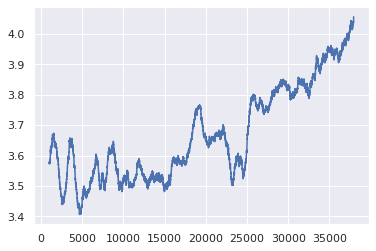

In [29]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

## Question 4: category_model

While location is important, we could also try seeing how predictive the
venue's category is. Build an estimator that considers only the `'categories'` field of the data.

The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to **one-hot encoding**, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. However, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one. For example, it should transform `X_in` into `X_out`.

In [31]:
X_in = pd.Series([['a'], ['b', 'c']])
X_out = pd.Series([{'a': 1}, {'b': 1, 'c': 1}])

print(X_in)
print(X_out)

0       [a]
1    [b, c]
dtype: object
0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object


In [32]:
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return pd.Series([{i:1 for i in j} for j in X.squeeze()])

Now let's test out that our `DictEncoder` works out as expected.

In [33]:
(DictEncoder().fit_transform(X_in)).shape

(2,)

In [34]:
# Check that DictEncoder transforms a series of list of strings into the expected series of dictionaries
grader.check((DictEncoder().fit_transform(X_in) == X_out).all())

True

Now, create a pipeline object of the two step transformation for the categories data. Afterwards, create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

dict_vectorizer = Pipeline([
        ('DictEncoder',DictEncoder()),
        (' DictVectorizer', DictVectorizer())
], verbose=True)


cat_transformer = ColumnTransformer([
    ('dict_vectorize', dict_vectorizer, ['categories'])
])

Finally, create a pipeline object that will
1. Convert our list of dictionaries into a data frame
1. Select the `'categories'` column and encode the data
1. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. Use cross validation to choose the best regularization parameter.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfTransformer



n_alphas = 50
alphas = np.logspace(-10, 3, n_alphas)

parameters = {'alpha': alphas}
ridge_ = Ridge()
ridge_grid = GridSearchCV(ridge_, parameters)



category_model = Pipeline([
        ('to_df',to_data_frame),
        ('cat_transformer',cat_transformer),
        ('TfidfTransformer',TfidfTransformer()),
        ('ridge_grid',ridge_grid)
], verbose=True)


category_model.fit(data, star_ratings)

[Pipeline] ............. (step 1 of 4) Processing to_df, total=   0.2s
[Pipeline] ....... (step 1 of 2) Processing DictEncoder, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing  DictVectorizer, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing cat_transformer, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing TfidfTransformer, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing ridge_grid, total=  17.6s


Pipeline(steps=[('to_df', ToDataFrame()),
                ('cat_transformer',
                 ColumnTransformer(transformers=[('dict_vectorize',
                                                  Pipeline(steps=[('DictEncoder',
                                                                   DictEncoder()),
                                                                  (' '
                                                                   'DictVectorizer',
                                                                   DictVectorizer())],
                                                           verbose=True),
                                                  ['categories'])])),
                ('TfidfTransformer', TfidfTransformer()),
                ('ridge_grid',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e...
       2.32995181e-04, 4.29193426e-04, 7.90604321e-04, 1.45634848e-03,
       2.68269580e-0

**Extension:** Some categories (e.g., Restaurants) are not very specific. Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term frequency-inverse document frequency (tf-idf). Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model, and see if that improves performance.

## Question 5: attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```
Build a custom transformer that flattens the dictionary for the `'attributes'` field. Similar to what was done before, create a model that properly encodes the attribute data and learns to predict the ratings.

You may find it difficult to find a single regressor that does well enough. A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit. Build a custom predictor that takes as an argument two other predictors. It should use the first to fit the raw data and the second to fit the residuals of the first.


In [46]:
# from collections.abc import MutableMapping

# def dict_flattener(X: MutableMapping):
#     parent_key = str()
#     sep = '_'
#     items= []
#     for k, v in X.items():
#         new_key = (parent_key + sep + str(k)) if parent_key else str(k)
#         if isinstance(v, MutableMapping):
#             items.extend(dict_flattener(v).items())
#         elif isinstance(v,bool):
#             items.append((new_key, int(v)))
#         elif isinstance(v,str):
#             if v.lower() == 'yes':
#                 items.append((new_key, 1))
#             elif v.lower() == 'no':
#                 items.append((new_key, 0))
#             else:
#                 newer_key = (new_key + sep + str(v))
#                 items.append((newer_key, 1)) 
#         elif isinstance(v,(int,float)):
#             items.append((new_key, v)) 

#     return dict(items)





# class DictFlatten(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y = None):
#         return self
    
#     def transform(self, X):
#         # X will be a pandas series. Return a pandas series of dictionaries
#         return pd.Series([dict_flattener(j) for j in X.squeeze()])

In [53]:
from collections.abc import MutableMapping

def dict_flattener(X: MutableMapping, parent_key = ''):
    sep = '_'
    items= []
    for k, v in X.items():
        new_key = (parent_key + sep + str(k)) if parent_key else str(k)
        if isinstance(v, MutableMapping):
            items.extend(dict_flattener(v, parent_key=new_key).items())
        elif isinstance(v,bool):
            items.append((new_key, int(v)))
        elif isinstance(v,str):
            if v.lower() == 'yes':
                items.append((new_key, 1))
            elif v.lower() == 'no':
                items.append((new_key, 0))
            else:
                newer_key = (new_key + sep + str(v))
                items.append((newer_key, 1)) 
        elif isinstance(v,(int,float)):
            items.append((new_key, v)) 

    return dict(items)



class DictFlatten(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return pd.Series([dict_flattener(j) for j in X.squeeze()])

In [54]:
# from sklearn.preprocessing import FunctionTransformer

# date_transformer = FunctionTransformer(dict_flattener)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

dict_vectorizer = Pipeline([
        ('DictFlatten',DictFlatten()),
        (' DictVectorizer', DictVectorizer())
], verbose=True)


cat_transformer_att = ColumnTransformer([
    ('dict_vectorize', dict_vectorizer, ['attributes'])
])

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import GradientBoostingRegressor



n_alphas = 50
alphas = np.logspace(-10, 3, n_alphas)

parameters = {'alpha': alphas}
ridge_ = Ridge()
ridge_grid = GridSearchCV(ridge_, parameters)



lr_att_model = Pipeline([
        ('to_df',to_data_frame),
        ('cat_transformer',cat_transformer_att),
#         ('TfidfTransformer',TfidfTransformer()),
        ('ridge_grid',GradientBoostingRegressor(n_estimators=1000))
], verbose=True)


att_model_lr = lr_att_model

att_model_lr.fit(data, star_ratings)

[Pipeline] ............. (step 1 of 3) Processing to_df, total=   0.2s
[Pipeline] ....... (step 1 of 2) Processing DictFlatten, total=   0.5s
[Pipeline] ... (step 2 of 2) Processing  DictVectorizer, total=   0.5s
[Pipeline] ... (step 2 of 3) Processing cat_transformer, total=   1.0s
[Pipeline] ........ (step 3 of 3) Processing ridge_grid, total=  21.0s


Pipeline(steps=[('to_df', ToDataFrame()),
                ('cat_transformer',
                 ColumnTransformer(transformers=[('dict_vectorize',
                                                  Pipeline(steps=[('DictFlatten',
                                                                   DictFlatten()),
                                                                  (' '
                                                                   'DictVectorizer',
                                                                   DictVectorizer())],
                                                           verbose=True),
                                                  ['attributes'])])),
                ('ridge_grid', GradientBoostingRegressor(n_estimators=1000))],
         verbose=True)

In [57]:
att_model_lr.predict(data)

array([3.90494074, 3.56955625, 3.81880401, ..., 3.68451971, 3.99400936,
       3.67765768])

In [134]:
# from sklearn.ensemble import RandomForestRegressor

# rf_regressor_nlr = RandomForestRegressor()

# rf_regressor = rf_regressor_nlr
# rf_regressor.fit(prediction.reshape(-1, 1), star_ratings)

# star_ratings - rf_regressor.predict(residual.reshape(-1, 1))

In [135]:
# from sklearn.tree import DecisionTreeRegressor

# model = DecisionTreeRegressor()
# model.fit(residual.reshape(-1, 1), star_ratings)

# star_ratings - model.predict(residual.reshape(-1, 1))

In [136]:
# # # n_alphas = 50
# # # alphas = np.logspace(-10, 3, n_alphas)

# # # parameters = {'alpha': alphas}
# # # ridge_ = Ridge()
# # # ridge_grid = GridSearchCV(ridge_, parameters)





# class EnsemblePredictor(BaseEstimator, RegressorMixin):
#     def fit(self, X, y):
#         lr_att_model = Ridge(alpha=7.543120063354638)
#         lr_att_model.fit(X,y)
#         prediction = lr_att_model.predict(X)
#         residual = (y - prediction)
#         rf_regressor_nlr = RandomForestRegressor()
# #         rf_regressor_nlr.fit(residual, y)
#         return rf_regressor_nlr.fit(residual.reshape(-1, 1),y)
    
#     def predict(self, X):

#         return rf_regressor_nlr.predict(X.reshape(-1, 1))
    
    
    
# lr_att_model_en = Pipeline([
#         ('to_df',to_data_frame),
#         ('cat_transformer',cat_transformer_att),
# #         ('TfidfTransformer',TfidfTransformer()),
#         ('EnsemblePredictor',EnsemblePredictor())
# ], verbose=True)



In [137]:
# lr_att_model_en.fit(data,star_ratings)

In [138]:
# Create the transformer to handle the attributes data

# Create the linear + non-linear ensemble predictor

# Create the attribute model

## Question 6: full_model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. Build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector. If you are just using Python lists, you will want a list of lists of single elements.

In [59]:
import numpy as np
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model = model
        return None
    
    def fit(self, X, y):
        self.model.fit(X,y)
        # Fit the stored predictor.
        # Question: what should be returned?
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.
        return np.array(self.model.predict(X)).reshape(-1,1)

Let's now test it out on our `city_model`.

In [63]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])

# Check that the transformation output is a 2-D array with one column
grader.check(np.array(X_t).shape[-1] == 1)

True

In [64]:
y_pred = np.array(city_model.predict(data[:5]))

# Check that the transformation output is the same as the model's predictions
grader.check((y_pred.reshape(-1, 1) == X_t).all())

True

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [65]:
from sklearn.pipeline import FeatureUnion

city_trans = ModelTransformer(city_model)
lat_long_trans = ModelTransformer(lat_long_to_star_ratings)
category_trans = ModelTransformer(category_model)
att_trans = ModelTransformer(att_model_lr)


union = FeatureUnion([
    ('city_trans',city_trans),
    ('lat_long_to_star_ratings',lat_long_trans),
    ('category_model',category_trans),
    ('attribute_model',att_trans)
        # FeatureUnion uses the same syntax as Pipeline
    ], verbose=True)

Our `FeatureUnion` object should return a feature matrix with four columns.

In [66]:
union.fit(data, star_ratings)


[FeatureUnion] .... (step 1 of 4) Processing city_trans, total=   0.0s
[Pipeline] ............. (step 1 of 3) Processing to_df, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline]  (step 3 of 3) Processing knn_regressor_grid, total=  20.8s
[FeatureUnion]  (step 2 of 4) Processing lat_long_to_star_ratings, total=  21.0s
[Pipeline] ............. (step 1 of 4) Processing to_df, total=   0.2s
[Pipeline] ....... (step 1 of 2) Processing DictEncoder, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing  DictVectorizer, total=   0.1s
[Pipeline] ... (step 2 of 4) Processing cat_transformer, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing TfidfTransformer, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing ridge_grid, total=  17.9s
[FeatureUnion]  (step 3 of 4) Processing category_model, total=  18.3s
[Pipeline] ............. (step 1 of 3) Processing to_df, total=   0.2s
[Pipeline] ....... (step 1 of 2) Processing DictFlatten, total=   0

FeatureUnion(transformer_list=[('city_trans',
                                ModelTransformer(model=CityRegressor())),
                               ('lat_long_to_star_ratings',
                                ModelTransformer(model=Pipeline(steps=[('to_df',
                                                                        ToDataFrame()),
                                                                       ('selector',
                                                                        ColumnTransformer(transformers=[('lat_long',
                                                                                                         'passthrough',
                                                                                                         ['latitude',
                                                                                                          'longitude'])])),
                                                                       ('knn_regressor_g

In [67]:
X_t = union.transform(data[:5])

# Transformed data should have 5 rows and 4 columns
grader.check(X_t.shape == (5, 4))

True

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

full_model = Pipeline([
        ('union_model',union),
#         ('random_forest_regressor',RandomForestRegressor())
        ('linear_regressor',LinearRegression())
], verbose=True)


full_model.fit(data, star_ratings)

[FeatureUnion] .... (step 1 of 4) Processing city_trans, total=   0.1s
[Pipeline] ............. (step 1 of 3) Processing to_df, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
